<a href="https://colab.research.google.com/github/MalikaIT21277122/TimeSeriesAnalysis/blob/main/Random_Forest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: Random Forest
Mean Squared Error (MSE): 10264.155829999998
Mean Absolute Error (MAE): 86.39519999999999
R² Score: -0.06949300736826114


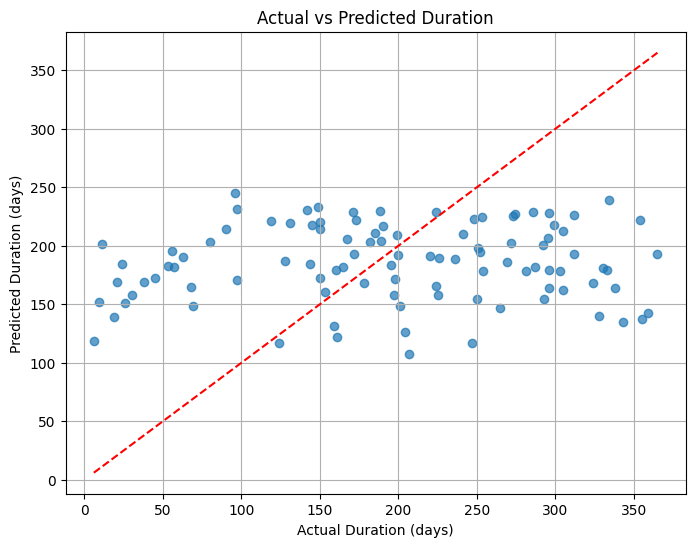

Predicted Duration for sample input: 178.43 days
Model Accuracy: 52.46%


In [22]:
# Import necessary libraries
# Pandas is used for data manipulation and analysis
# Numpy is used for numerical operations
# train_test_split is used to split data into training and testing sets
# RandomForestRegressor is the model we are using
# Metrics like MSE, MAE, and R² are used to evaluate the model's performance
# Matplotlib is used to plot graphs

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# The dataset "CESAW_project_summary_Cleaned.csv" is loaded using pandas
# The dataset contains information about team size, lines of code (A&M_LoC), effort hours, and project duration
file_name = "CESAW_project_summary_Cleaned.csv"
data = pd.read_csv(file_name)

# Step 2: Prepare the data
# Select features (independent variables) and target variable (dependent variable)
# In this case, we are using 'Team_Size', 'A&M_LoC', and 'Effort_Hours' as features
# and 'Duration_Days' as the target variable that we want to predict

X = data[['Team_Size', 'A&M_LoC', 'Effort_Hours']]  # Features
y = data['Duration_Days']  # Target variable

# Split the dataset into training and testing sets (80% training, 20% testing)
# Random_state is set to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
# We are using the RandomForestRegressor to predict the project duration
# n_estimators=100 means the model will use 100 decision trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Predict and evaluate the model
# Using the trained model to predict project duration on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics to assess the model's performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print the metrics
# MSE and MAE help us understand the model's prediction errors,
# while R² score tells us how well the model fits the data
print("Model: Random Forest")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Step 5: Plot Actual vs Predicted values
# A scatter plot is used to visualize the comparison between actual and predicted durations
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)  # Plot the actual vs predicted points
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line representing perfect predictions
plt.title("Actual vs Predicted Duration")  # Title of the graph
plt.xlabel("Actual Duration (days)")  # X-axis label
plt.ylabel("Predicted Duration (days)")  # Y-axis label
plt.grid(True)  # Add grid lines for better readability
plt.show()  # Display the plot

# Step 6: Predict for a sample input
# This function takes sample input values for 'Team_Size', 'A&M_LoC', and 'Effort_Hours'
# and predicts the project duration using the trained Random Forest model
sample_input = pd.DataFrame({
    'Team_Size': [30],
    'A&M_LoC': [250000],
    'Effort_Hours': [7500]
})
predicted_duration = rf_model.predict(sample_input)[0]
print(f"Predicted Duration for sample input: {predicted_duration:.2f} days")

# Step 7: Calculate Accuracy
# Accuracy is calculated as 1 minus the ratio of Mean Absolute Error to the average duration
# This gives us an indication of how accurate the model's predictions are
average_duration = y.mean()
accuracy = 1 - (mae / average_duration)
print(f"Model Accuracy: {accuracy:.2%}")

# The code and the model were developed manually as part of the project work.
